## Report by KHOUTAIBI Iliass and KHALIL Yacine

The goal of this report, is to solve the following least square equation:  
$\begin{align}
    \min_{w \in \mathbb{R}^d} \frac{1}{2} \lVert Aw -b \lVert^2
\end{align}$ 
where $(Aw)_{t} = \tilde{x}^T\cdot w_{1} + w_{0} - y(t)\tilde{x}^T\cdot w_{2}$ and $b_{t} = y(t)$

1. Suppose that $Aw = b$

we find that $(Aw)_{t} = b_{t}$, then we have that:  
$\begin{align}
    \tilde{x}^T\cdot w_{1} + w_{0} - y(t)\tilde{x}^T\cdot w_{2} = y_{t}
    \Rightarrow \tilde{x}^T\cdot w_{1} + w_{0} = y_{t}(1+\tilde{x}^T\cdot w_{2})
    \nonumber
\end{align}$
finally 
$\begin{align}
    y_{t} = \frac{\tilde{x}^T\cdot w_{1} + w_{0}}{1+\tilde{x}^T\cdot w_{2}} 
    \nonumber
\end{align}$

2. solve this least squares problem using the function numpy.linalg.lstsq

The code down below solves the least square problem using the numpy module, we start by importing the data base and building the data matrix A.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time

In [2]:
# Loading data using numpy
data_matrix_train, COP_train, data_matrix_test, COP_test, names = np.load('data_center_data_matrix.npy', allow_pickle=True)

In [3]:
# centering and normalizing the matrix
matrix_mean = np.mean(data_matrix_train, axis=0)
M = data_matrix_train - matrix_mean

matrix_std = np.std(M, axis=0)
M = M / matrix_std

In [4]:
# Printing the shape of the matrix here
M.shape

(722, 892)

In [5]:
# Building the corresponding matrices A,b for linear regression
A = np.hstack([M, np.ones((M.shape[0],1)), -(M.T * COP_train[:,3]).T])
b = COP_train[:,3]

# Building the same matrices for the test set
M_test = (data_matrix_test - matrix_mean) / matrix_std
A_test = np.hstack([M_test, np.ones((M_test.shape[0],1)), -(M_test.T * COP_test[:,3]).T])
b_test = COP_test[:,3]

d = A.shape[1]

The np.linalg.lstsq funciton returns a tuple, its first element is the result and its second element is the error

In [6]:
# Getting the least square result
w_least_squares = np.linalg.lstsq(A,b,rcond=None)[0]
print(f"the least square w is :{w_least_squares}")

the least square w is :[-0.00927821  0.08309371 -0.03672704 ...  0.01980595 -0.03057174
 -0.01188614]


3. Evaluate the quality of the solution found on the test set, by computing the mean-squared
error 
$\begin{align}
    \frac{1}{N_{test}}\lVert A_{test}w -b_{test} \lVert^2  
\end{align}$

In [7]:
#Evaluating the least squre result

N_test = A_test.shape[0]
test_error = (1/N_test) *(np.linalg.norm(A_test @ w_least_squares - b_test)**2)
print("Test error for least squares solution : ", test_error)

Test error for least squares solution :  780.8984793523729


In order to improve the performance on the test set, we add $\ell_2$ regularization:

$$
\min_{w \in \mathbb{R}^d} \frac 12 \|Aw-b\|_2^2 + \frac \lambda 2 \|w\|_2^2
$$

we also set $\lambda = 10^{4}$

4. Calculate the gradient of $f_{1}: w \rightarrow \frac 12 \|Aw-b\|_2^2 + \frac \lambda 2 \|w\|_2^2 $

we know that for a differentiable function $f$ : 
$$
    df_{w}(h) = \lang \nabla f(w), h \rang
$$

and that for a Bilinear product $B$, and two differentiable function $f$, $g$ and $\forall w,h \in \mathbb{R}^d $:  
$$  
    dB(f,g)_{w}(h) = B(df_{w}(h),g(w)) + B(f(w),dg_{w}(h))
$$

In our case, the Bilinear product is: $w \rightarrow \frac 12 \|Aw-b\|_2^2 + \frac \lambda 2 \|w\|_2^2$

Moreover, we know that $d(s \rightarrow As-b)_{w}(h) = Ah$ and $d(s \rightarrow s)_{w}(h) = h$

we finally find that:

$$d(f_{1})_{w}(h) =  d(s \rightarrow \frac 12 \lang As-b, As-b \rang + \frac \lambda 2 \lang s , s \rang )_{w}(h)\\ = \lang Aw -b , Ah \rang + \lambda \lang w , h \rang$$

Moreover, we have that $\lang Aw -b , Ah \rang = \lang A^{T}(Aw -b) , h \rang$

finally, $$ d(f_{1})_{w}(h) = \lang A^{T}(Aw -b) + \lambda w, h \rang$$

thus,  $\forall w \in \mathbb{R}^d$ 
$$\nabla f_{1}(w) = A^{T}(Aw -b) + \lambda w$$ 

We know that $w \rightarrow \Vert w \Vert$ is convex and $x \rightarrow x^2$ is convex, then $w \rightarrow \Vert w \Vert^2$ is convex. We also have $w \rightarrow \Vert Aw - b \Vert^2$ is convex from the course and since $\lambda \gt 0$, we conclude that $f_1$ is convex.

In [8]:
# Initilising the lambda 
lambda_l2 = 1e4

# the function to compute
def f(w,lambda_train = lambda_l2):
    return 1/2 * np.linalg.norm(A@w - b)**2 + lambda_train/2 * np.linalg.norm(w)**2 

# Computing the gradient
def grad_f(w):
    return (A.T)@(A@w - b) + lambda_l2*w

# Gradient descent Algorithm
def gradient_descent(func,w0, gamma, max_iter):
    start = time.time()
    w = w0.copy()
    f_values = []
    gradient_norms = []
    for t in range(max_iter): 
        w = w - gamma*grad_f(w)
        f_values.append(func(w))
        gradient_norms.append(np.linalg.norm(grad_f(w)))
    end = time.time()
    execution_time_GD = end-start
    return w, f_values, gradient_norms, execution_time_GD

For finding the appropriate step size range, we need to estimate the Lipschitz constant of the gradient.  

We know that $$ \nabla f(w) = A^{T}(Aw -b)$$

thus, for $x, y \in $ we have that :  
$$\Vert \nabla f(x) - \nabla f(y) \Vert_2 = \Vert A^TA (x-y)\Vert_2 \leq \lvert\lvert\lvert A^TA \lvert\lvert\lvert \cdot\Vert x-y \Vert_2   $$

thus the Lipshitz constant is equal to $\lvert\lvert\lvert A^TA \lvert\lvert\lvert$ which corresponds to the biggest eigenvalue of $A^{T}A$

In [9]:
# Finding the appropriate Lipshitz constant
L = np.real(np.max(np.linalg.eigvals(A.T @ A)))

In [10]:
# Computing Gradient descent
w0 = np.zeros_like(w_least_squares)
# We choose the step size eqaul to 1/L
step_size = 1/L
max_iter = 300
w_GD, f_values_GD, gradient_norms_GD, execution_time_GD = gradient_descent(f,w0, step_size, max_iter)

Text(0, 0.5, 'Function values')

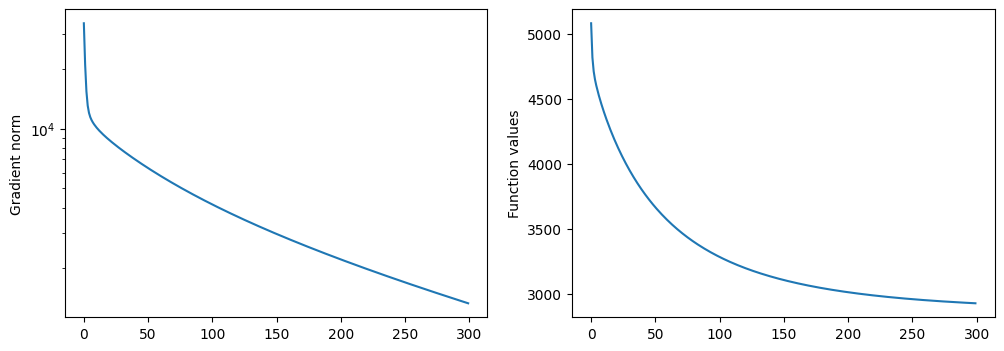

In [11]:
# Plotting the results
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

axes[0].plot(gradient_norms_GD)
axes[0].semilogy()
axes[0].set_ylabel("Gradient norm")

axes[1].plot(f_values_GD)
axes[1].set_ylabel("Function values")

In [12]:
# Comparing with least square
test_error_l2 = 1/N_test * np.linalg.norm(A_test@w_GD - b_test)**2
print("Test error for l2 penalized solution : ", test_error_l2)

Test error for l2 penalized solution :  38.250345207256785


We notice that the gradient descent method yields results with less error than the least square one ! However, we can continue improving our results using accelerated gradient descent to speed up the results. 

5. Computing the accelerated gradient descent :

In [13]:
# Accelerated gradient descent
def accelerated_gradient_descent(func, w0, y0,gamma, max_iterm,lambda_train = lambda_l2):
    start = time.time()
    w = w0.copy()
    y = y0.copy()
    y_memory = y
    f_values = []
    gradient_norms = []
    for t in range(max_iterm):
        beta = (t+1)/(t+4)
        y = w - gamma*grad_f(w)
        w = y + beta*(y-y_memory)
        f_values.append(func(w,lambda_train))
        gradient_norms.append(np.linalg.norm(grad_f(w)))
        y_memory = y
    end = time.time()
    execution_time_AGD = end-start
    return w, f_values, gradient_norms, execution_time_AGD

In [14]:
# Computing the accelerated varient
w0 = np.zeros_like(w_least_squares)
y = np.zeros_like(w_least_squares)
step_size = 1/L
max_iter = 300

w_AGD, f_values_AGD, gradient_norms_AGD, execution_time_AGD = accelerated_gradient_descent(f, w0, y,step_size, max_iter)

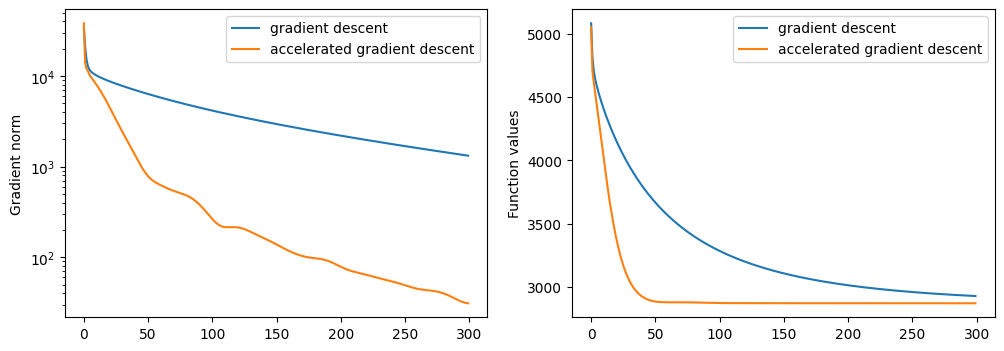

In [15]:
# let us plot the result 
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

axes[0].plot(gradient_norms_GD, label = "gradient descent")
axes[0].plot(gradient_norms_AGD, label = "accelerated gradient descent")
axes[0].semilogy()
axes[0].set_ylabel("Gradient norm")
axes[0].legend()

axes[1].plot(f_values_GD, label = "gradient descent")
axes[1].plot(f_values_AGD, label = "accelerated gradient descent")
axes[1].set_ylabel("Function values")
axes[1].legend()
plt.show()

As we can see, instead of converging in 300 iteratons, the accelerated gradient descent method reaches the minimal value in less than 100 ! This method converges faster than the normal gradient descent algorithm.

In order to get a more informative minimal value, we will use the $\ell_{1}$ regularization, i.e:

$$
\min_{w \in \mathbb{R}^d} \frac 12 \|Aw-b\|_2^2 + \lambda \|w\|_1
$$

6. Write the objective function as $F_2 = f_2 + g_2$ where $f_2$ is differentiable and the proximal
operator of $g_2$ is easy to compute. Recall the formula for $prox_{\gamma g_2}$ . Calculate the gradient of
$f_2$.

In our case, we have that $f_2 = \|Aw-b\|_2^2$ and $ g_2 = \lambda \|w\|_1$, moreover we know that for this simple function $g_2$ 
$$ \text{prox}_{\gamma g_2}(x) = S_{\gamma\lambda}(x) $$
where    $$ S_{\gamma\lambda}(x)_{i} = \begin{cases}
    x_{i} + \lambda\gamma \quad \text{if} \quad x_{i} \lt -\lambda\gamma \\
    0 \quad \text{if} -\lambda\gamma \leq x_{i} \leq \lambda\gamma \\
    x_{i} - \lambda\gamma \quad \text{if} \quad \lambda\gamma \lt x_{i}\\
\end{cases}$$

In addition, the gradient of $f_2$ according to the previous questions:
    $$\nabla f_2(w) = A^T(Aw -b)$$

In [16]:
lambda_l1 = 1e3

#Computing the proximal value for the simple function
def prox_l1(x, gamma, mu = 1.):
    """compute the proximal operator of mu * |x|_1
    """
    S = np.zeros_like(x)
    for i in range(len(x)) :
        if x[i] < -mu*(gamma):
            S[i] = x[i] + mu*gamma
        elif -mu*gamma <= x[i] <= mu*gamma:
            S[i] = 0
        elif mu*gamma < x[i]:
            S[i] = x[i] - mu*gamma
    
    return S

# Computing the gradient of f2
def grad_f2(w) :
    return (A.T)@(A@w - b)

# Computing the proximal gradient descent
def proximal_gradient_descent(func, w0, gamma, max_iter):
    start = time.time()
    w = w0.copy()
    f_values = []
    gradient_norm = []
    for t in range(max_iter):
        w = prox_l1(w - gamma*grad_f2(w),gamma,lambda_l1)
        f_values.append(func(w))
        gradient_norm.append(np.linalg.norm(grad_f2(w)))
    end = time.time()
    execution_time_proximal = end-start
    return w , f_values, gradient_norm, execution_time_proximal

In [17]:
# Computing the proximal gradient descent minimum
w0 = np.zeros_like(w_least_squares)
step_size = 1/L
max_iter = 300
w_PGD, f_values_PGD, gradient_norms_PGD, execution_time_PGD = proximal_gradient_descent(f, w0, step_size, max_iter)

In [18]:
# Computing the error
test_error_l1 = 1/N_test *(np.linalg.norm(A_test @ w_PGD - b_test))**2
print("Test error for l1 penalized solution : ", test_error_l1)

Test error for l1 penalized solution :  19.681201169883657


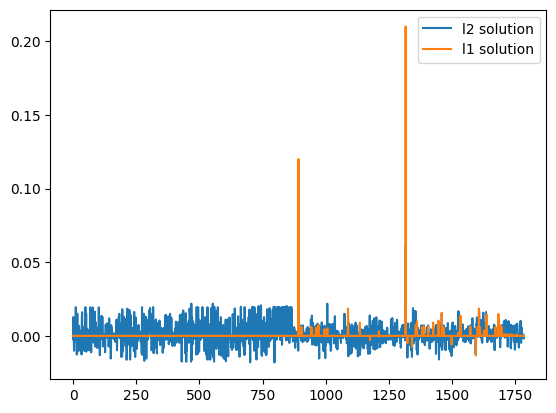

In [19]:
# Let us examine the solution
plt.plot(w_GD, label = "l2 solution")
plt.plot(w_PGD, label = "l1 solution")
plt.legend()
plt.show()

We notice that, instead of leaving the noisy values near zero like the $\ell_2$ soluting, we only leave the important values and put the rest at zero. We also notice that for the important values, i.e the peaks, the values are almost the same.

In order to accelerate the reuslts even more, we will use the accelerated linesearch algorithm we learned in the course. The implementation of the algorithm in down below:

In [20]:
# computing the accelerated linesearch algorithm
def proximal_gradient_descent_linesearch(func, w0, gamma, max_iter):
    start = time.time()
    w = w0.copy()
    f_values = []
    grad_values = []
    gamma_plus = 0
    while(max_iter):
        gamma_plus = gamma
        while(True): 
            w_plus = w - gamma_plus*grad_f(w)
            if func(w_plus) <= func(w) + (w_plus - w).T @ grad_f(w) + (1/(2*gamma_plus))*np.linalg.norm(w_plus-w)**2 :
                w = w_plus 
                gamma = 2*gamma_plus
                break
            else :
                gamma_plus = gamma_plus/2
        
        f_values.append(func(w))
        grad_values.append(np.linalg.norm(grad_f(w)))
        max_iter -= 1
    end = time.time()
    execution_time_linesearch = end-start
    return w , f_values, grad_values, execution_time_linesearch

In [21]:
# Computing the accelerated linesearch
w0 = np.zeros_like(w_least_squares)
step_size = 1
max_iter = 300
w_linesearch, f_values_linesearch, gradient_norms_linesearch, execution_time_linesearch = proximal_gradient_descent_linesearch(f, w0, step_size, max_iter)

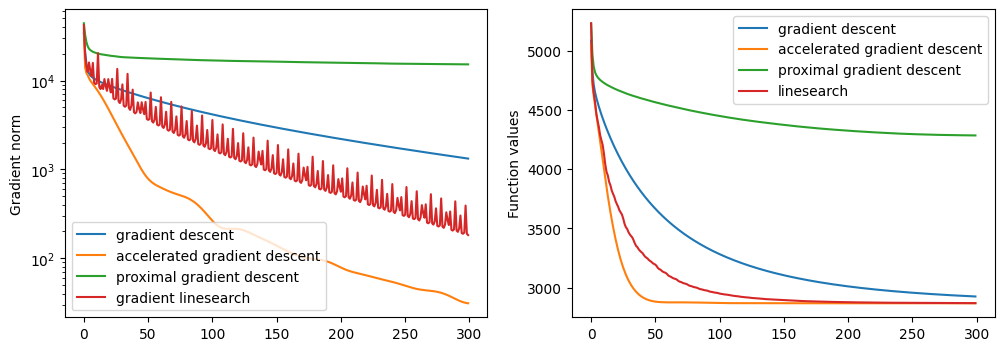

In [22]:
# let us plot the result 
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

axes[0].plot(gradient_norms_GD, label = "gradient descent")
axes[0].plot(gradient_norms_AGD, label = "accelerated gradient descent")
axes[0].plot(gradient_norms_PGD, label = "proximal gradient descent")
axes[0].plot(gradient_norms_linesearch, label = "gradient linesearch")

axes[0].semilogy()
axes[0].set_ylabel("Gradient norm")
axes[0].legend()

axes[1].plot(f_values_GD, label = "gradient descent")
axes[1].plot(f_values_AGD, label = "accelerated gradient descent")
axes[1].plot(f_values_PGD, label = "proximal gradient descent")
axes[1].plot(f_values_linesearch, label = "linesearch")
axes[1].set_ylabel("Function values")
axes[1].legend()

plt.show()

In [23]:
# Getting the execution times of the algorithms
print(f"Execution time of GD is {execution_time_GD}s")
print(f"Execution time of AGD is {execution_time_AGD}s")
print(f"Execution time of proximal is {execution_time_PGD}s")
print(f"Execution time of linesearch is {execution_time_linesearch}s")

Execution time of GD is 0.45015597343444824s
Execution time of AGD is 0.49573540687561035s
Execution time of proximal is 1.3473725318908691s
Execution time of linesearch is 3.331397294998169s


We notice that linesearch is incredibly fast, since we do not iterate on all of the values !

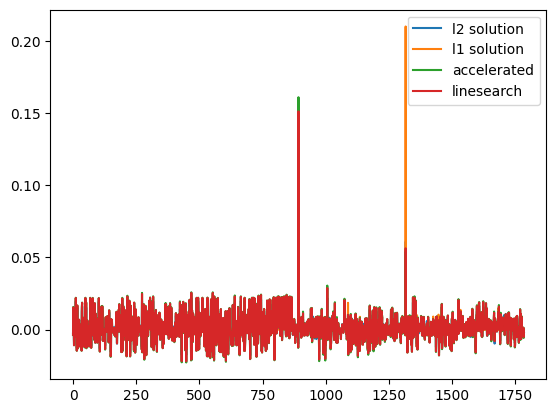

In [24]:
plt.plot(w_GD, label = "l2 solution")
plt.plot(w_PGD, label = "l1 solution")
plt.plot(w_AGD, label="accelerated")
plt.plot(w_linesearch, label="linesearch")
plt.legend()
plt.show()

## Tuning the penalization parameter

How to find the best solution among all those that were comptued? How to choose the penalization parameter $\lambda$?